### Here we investigate 3 coupled nonlinear oscillators [cont.]

This notebook demo's the basic process for finding transitions in the oscillators as a function of Pulse apmplitude and Noise volume, $T(P_0, C_n)$. The idea is to find the minimum value of first oscillator's constant $C_1$, such that the pulse is sufficent to trigger the transition, despite there being some positive noise.

<b>Set Up

In [1]:
import numpy as np
from numpy import sin, sqrt, pi, exp
from scipy.integrate import solve_ivp
from scipy.interpolate import BSpline
from matplotlib import pyplot as plt

$\dot{y}_1 = - \gamma_1 y_1 - \sin{x_1} + C_1 + \kappa_{12}(x_2-x_1) + C_n N(t) + P(t)$<br>
$\dot{y}_2 = - \gamma_2 y_2 - \sin{x_2} + C_2 + \kappa_{12}(x_1-x_2) + \kappa_{23}(x_3+x_2)$<br>
$\dot{y}_3 = - \gamma_3 y_3 - \sin{x_3} + C_3 + \kappa_{23}(x_2-x_3)$

<br>
$N(t)$ = $Noise.dat$ file

<br>

$P(t)=\frac{P_0}{\sigma \sqrt{2\pi}} e^{-\frac{(t-t_0)^2}{2\sigma^2}}$

We start with our initial conditions IC and constants.

In [2]:
#Constants [gamma1,2,3, C1,2,3, kappa12,23]
g1, g2, g3, C2, C3, k12, k23 = [0.7, 1.1, 0.7, 0.8, -1.0, 0.1, 0.1]

#Special parameters (to be modified as we go)
sigma = 10   #pulse spread (wavelength)
t0 = 100     #initial time

Now we pull $N(t)$ from our local $Noise.dat$ file.<br>

In [3]:
#Read data from file
data = np.genfromtxt('Noise.dat')

#Reconstruct data (split back into two separate arrays)
t = data[:,0]
Nt = data[:,1]

Now that we have our noise file, we need to smooth or interpolate it for more points. <br>
Thankfully Scipy has a useful function for this, which actually returns a new smooth $N_s(t)$. <br>
We'll do this down 2 orders of magnitude, thus increasing our total points from 5,000 to 500,000* <br>

*Technically we'll have 499000 points in $N_s(t)$, because we skip 1000 in between 0-1, which doesn't affect our end result.

In [64]:
#define new time space (starts at 1 not 0 because noise.dat starts at non-zero value)
dt = 0.01
ts = np.arange(0, 500, dt)

#grab interpolation class
#newy = BSpline(xnew, oldy, order)
S = BSpline(t, Nt, 2)

Ns = S(ts)
print("old size: " + str(len(Nt)))
print("new size: " + str(len(Ns)))

old size: 5000
new size: 50000


Of course these plots don't look any different at full scale, but if we zoom in they will. <br>

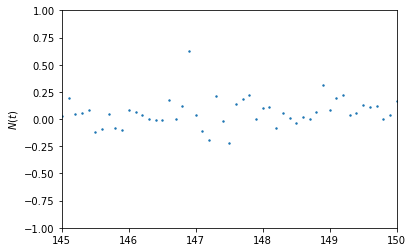

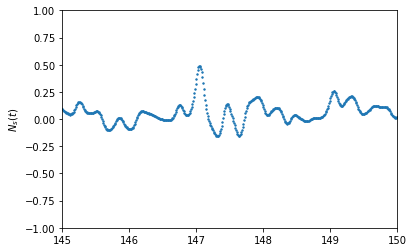

In [65]:
#Plot original N(t)
plt.scatter(t, Nt, s=2)
plt.xlim(145, 150)
plt.ylim(-1, 1)
plt.ylabel('$N(t)$')
plt.show()

#Plot smoothed Ns(t)
plt.scatter(ts, Ns, s=2)
plt.xlim(145, 150)
plt.ylim(-1, 1)
plt.ylabel('$N_s(t)$')
plt.show()

In plotting scatter points for data, we can directly see the interpolation, and so choose its kind. <br>
Plot shows 5s span  - 50pts for $N(t)$, and 5000 for $N_s(t)$, as seen here for <b>2nd order smoothing</b>.

Additionally, it would be convenient if a range (slice) could be selected arbitrarily. <br>
And importantly, we need to be able to scale the noise in the range we select such that its average over that range is zero. <br>
For this we will define the following function.

In [66]:
#Grab mean-adjusted slice from noise and associated time slice (here 70-130)
N1 = Ns[int(80/dt):int(120/dt)]
t1 = ts[int(80/dt):int(120/dt)]
N1 = N1 - np.average(N1)

<b>Modeling

From here we can proceed to the modeling phase. <br>
The pulse $P(t)$ will be added to the first oscillator during the integration below. <br>
Yet first we will define it so that we can make sure it's working as we expect.

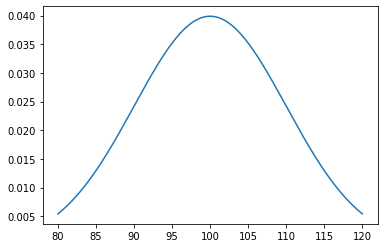

0.039894228040143274 0.039894228040143274


In [68]:
Pt = 1/(sigma*sqrt(2*pi))*exp(-pow(t1-t0, 2)/(2*pow(sigma,2)))
plt.plot(t1, Pt)
plt.show()
print(Pt[2000], max(Pt))

First we have $v1$ which omits the pulse $P(t)$, then we have $v2$ which includes it for comparative purposes.

In [75]:
def v1(t, v, c1, cn):
    #print(int((t-(t0-2*sigma))/dt))
    x1, y1, x2, y2, x3, y3 = v
    Z = [y1, - g1*y1 - sin(x1) + c1 + k12*(x2-x1) + cn*N1[int((t-(t0-2*sigma))/dt)],
         y2, - g2*y2 - sin(x2) + C2 + k12*(x1-x2) + k23*(x3-x2), 
         y3, - g3*y3 - sin(x3) + C3 + k23*(x2-x3)]
    return Z

In [71]:
def v2(t, v, c1, cn, p0):
    #print(int((t-(t0-2*sigma))/dt))
    x1, y1, x2, y2, x3, y3 = v
    Z = [y1, - g1*y1 - sin(x1) + c1 + k12*(x2-x1) + cn*N1[int((t-(t0-2*sigma))/dt)] + 
         p0/(sigma*sqrt(2*pi))*exp(-pow(t-t0, 2)/(2*pow(sigma,2))),
         y2, - g2*y2 - sin(x2) + C2 + k12*(x1-x2) + k23*(x3-x2), 
         y3, - g3*y3 - sin(x3) + C3 + k23*(x2-x3)]
    return Z

<b>Plotting

In [78]:
def myplot(x1, y1, y2, y3, dx, title):
    plt.plot(x1, y1, 'b')
    plt.plot(x1, y2, 'g')
    plt.plot(x1, y3, 'r')
    plt.title(title)
    plt.xlabel('$t$')
    if dx:
        plt.ylabel('$\dot{x}_1, \dot{x}_2, \dot{x}_3$')
        plt.legend((r'$\dot{x}_1$', r'$\dot{x}_2$', r'$\dot{x}_3$'))
    else:
        plt.ylabel('$x_1, x_2, x_3$')
        plt.legend((r'$x_1$', r'$x_2$',  r'$x_3$'))
    plt.show()

Since we've already tested the fact that these models work (see last notebook), we move onto manipulating $C_1$ and $P_0$. <br>

We seek to explore the state transition.

Here below we've found the transition given these other conditions, where $C_1\approx 2.8$, and $P_0\approx 5$

In [73]:
IC1 = [39.7, 0.0, 20.4, 0.0, 1.3, 0.0]
IC2 = [0.7, 0.0, 0.38, 0.0, 0.31, 0.0]
IC3 = [7.4, 0.0, 6.4, 0.0, -0.3, 0.0]
IC4 = [14.4, 0.0, 6.4, 0.0, -0.3, 0.0]

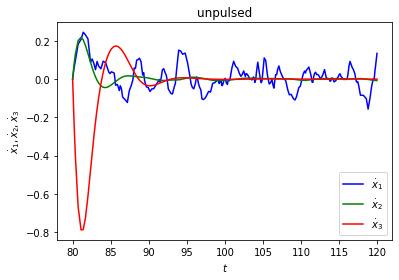

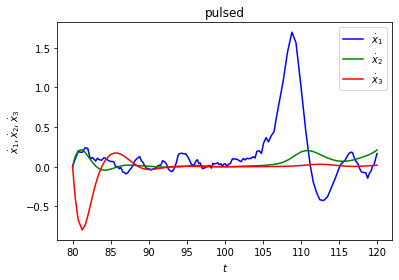

In [79]:
#Adjust parameters

IC = IC2

Cn = 1
P0 = 3.2
C1 = 1


#Run the models
z1 = solve_ivp(v1, [t1[0], t1[-1]], IC, args=(C1,Cn), dense_output=True)
z2 = solve_ivp(v2, [t1[0], t1[-1]], IC, args=(C1,Cn,P0), dense_output=True)

#Plot new results
myplot(z1.t, z1.y[1], z1.y[3], z1.y[5], 1, 'unpulsed')
myplot(z2.t, z2.y[1], z2.y[3], z2.y[5], 1, 'pulsed')
#plt.show()

Remember, the first plot is $z_1(t)$, with no pulse, and the second is $z_2(t)$ with a pulse (all other parameters the same). <br>

Now we see a real effect, with the lower plot clearly undergoing transition thanks to $P(t)$. <br>
And indeed, if we reduce $P_0$ down from 5 to 4, in keeping $C_1$ constant, the transition disappears.

In [ ]:
#Plot new results
plt.plot(t1, z1.y[0], label='unpulsed')
#plt.xlim(t0-3*sigma, t0+3*sigma)
plt.plot(t1, z2.y[0], label='pulsed')
#plt.xlim(t0-3*sigma, t0+3*sigma)
plt.ylabel('$x_1(t)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

Now that we have a good place to start, we move forward my creating a function which will reset the model with a given $P_0$, and test variable $C_1$. To test for state transition, we use the condition that *any* $\dot{x}_1 > 2.5 ⇒ transition$. <br>

By these means we will be able to note the minimal $C_1$ required to change state, for each $P_0 = [0, 5]$ with $\Delta P_0=0.1$.

This function is called $transition$, and will be called with a function called $zoom$, which searches the nearby resolution incrementally to save computational time. <br>

Therefore we will be able to find $T(P_0, C_n)$ with minimum $C_1$, given multiple initial conditions.